In [120]:
%load_ext autoreload
%autoreload 2

import os
import sys

import torch
from torch.optim import SGD
from torch import nn

## Access src directory from ./notebooks/ folder
from pathlib import Path
sys.path.append(str(Path('.').absolute().parent))

from src.Snip import SNIP
from src.models import ConvNet
from src.optimization import epoch

import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Manual test with F-MNIST

In [121]:
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms

# Prepare dataloaders

In [122]:
pruning_batch_size = 128
batch_size = 64
path = '../data/'
data_transforms = transforms.Compose([
    transforms.ToTensor()
])
train_dataset = FashionMNIST(path, train=True, download=True,transform=data_transforms)
test_dataset = FashionMNIST(path, train=False, download=True,transform=data_transforms)
pruning_data_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=pruning_batch_size, shuffle=True, num_workers=2)

train_data_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, num_workers=2)
test_data_loader = torch.utils.data.DataLoader(test_dataset,
                        batch_size=batch_size, shuffle=True, num_workers=2)

# Train the model
In the beginning of each batch, use pruning to force the connections to zero.

In [140]:
def train_model(model, snip = None, epochs = 20):

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    model = model.cuda()
    criterion = criterion.cuda()
    
    if snip:
        hooks = snip.register_masks()
        assert snip.K == snip.get_nonzero_param_number()

    train_losses = []
    test_losses = []
    accuracys = []
    # On itère sur les epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Phase de train
        _, loss = epoch(train_data_loader, model, criterion,snip_pruning=snip, optimizer=optimizer)
        # Phase d'evaluation
        with torch.no_grad():
            acc_test, loss_test = epoch(test_data_loader, model, criterion)

        train_losses.append(loss.avg)
        test_losses.append(loss_test.avg)
        accuracys.append(acc_test.avg)

    if snip:
        for hook in hooks:
            hook.remove()
        nonzero_params = snip.get_nonzero_param_number()
        print(nonzero_params)
        assert snip.K == nonzero_params

    return train_losses, test_losses, accuracys

def print_losses_and_acc(training_losses_, test_losses_, acc_):
    plt.title("L'erreur moyenne d'un patch dans generation des noms")
    plt.plot(np.arange(len(training_losses_)), training_losses_, label="Train")
    plt.plot(np.arange(len(test_losses_)), test_losses_, label="Test")
    plt.ylabel("L'erreur")
    plt.xlabel('Epochs')
    plt.legend()
    plt.figure()
    plt.plot(np.arange(len(acc_)), acc_)
    plt.show()

In [141]:
original_model = ConvNet()
train_losses, test_losses, accuracys  = train_model(original_model);

=== EPOCH 1 =====

[TRAIN Batch 000/938]	Time 0.059s (0.059s)	Loss 2.3106 (2.3106)	Prec   0.0 (  0.0)

[TRAIN Batch 100/938]	Time 0.003s (0.004s)	Loss 0.2502 (0.9786)	Prec   1.0 (  0.7)

[TRAIN Batch 200/938]	Time 0.003s (0.004s)	Loss 0.1557 (0.6264)	Prec   1.0 (  0.8)

[TRAIN Batch 300/938]	Time 0.003s (0.004s)	Loss 0.2530 (0.4834)	Prec   0.9 (  0.9)

[TRAIN Batch 400/938]	Time 0.004s (0.004s)	Loss 0.0894 (0.3972)	Prec   1.0 (  0.9)

[TRAIN Batch 500/938]	Time 0.003s (0.004s)	Loss 0.1366 (0.3409)	Prec   1.0 (  0.9)

[TRAIN Batch 600/938]	Time 0.004s (0.004s)	Loss 0.1211 (0.3024)	Prec   1.0 (  0.9)

[TRAIN Batch 700/938]	Time 0.004s (0.004s)	Loss 0.0400 (0.2719)	Prec   1.0 (  0.9)

[TRAIN Batch 800/938]	Time 0.003s (0.004s)	Loss 0.0515 (0.2490)	Prec   1.0 (  0.9)

[TRAIN Batch 900/938]	Time 0.003s (0.004s)	Loss 0.0417 (0.2317)	Prec   1.0 (  0.9)


===============> Total time 3s	Avg loss 0.2258	Avg Prec  0.93 %

[EVAL Batch 000/157]	Time 0.097s (0.097s)	Loss 0.0444 (0.0444)	Prec   1.0 (

[EVAL Batch 100/157]	Time 0.001s (0.003s)	Loss 0.0014 (0.0452)	Prec   1.0 (  1.0)


===============> Total time 0s	Avg loss 0.0450	Avg Prec  0.99 %

=== EPOCH 8 =====

[TRAIN Batch 000/938]	Time 0.077s (0.077s)	Loss 0.0025 (0.0025)	Prec   1.0 (  1.0)

[TRAIN Batch 100/938]	Time 0.003s (0.004s)	Loss 0.0016 (0.0091)	Prec   1.0 (  1.0)

[TRAIN Batch 200/938]	Time 0.003s (0.004s)	Loss 0.0064 (0.0104)	Prec   1.0 (  1.0)

[TRAIN Batch 300/938]	Time 0.004s (0.004s)	Loss 0.0151 (0.0107)	Prec   1.0 (  1.0)

[TRAIN Batch 400/938]	Time 0.004s (0.004s)	Loss 0.0033 (0.0106)	Prec   1.0 (  1.0)

[TRAIN Batch 500/938]	Time 0.006s (0.004s)	Loss 0.0008 (0.0109)	Prec   1.0 (  1.0)

[TRAIN Batch 600/938]	Time 0.003s (0.004s)	Loss 0.0811 (0.0107)	Prec   1.0 (  1.0)

[TRAIN Batch 700/938]	Time 0.004s (0.004s)	Loss 0.0028 (0.0110)	Prec   1.0 (  1.0)

[TRAIN Batch 800/938]	Time 0.003s (0.004s)	Loss 0.0293 (0.0119)	Prec   1.0 (  1.0)

[TRAIN Batch 900/938]	Time 0.003s (0.004s)	Loss 0.0172 (0.0124)	Prec   1.0 (

[EVAL Batch 000/157]	Time 0.076s (0.076s)	Loss 0.0065 (0.0065)	Prec   1.0 (  1.0)

[EVAL Batch 100/157]	Time 0.004s (0.003s)	Loss 0.1496 (0.0405)	Prec   1.0 (  1.0)


===============> Total time 0s	Avg loss 0.0416	Avg Prec  0.99 %

=== EPOCH 15 =====

[TRAIN Batch 000/938]	Time 0.082s (0.082s)	Loss 0.0011 (0.0011)	Prec   1.0 (  1.0)

[TRAIN Batch 100/938]	Time 0.003s (0.004s)	Loss 0.0003 (0.0053)	Prec   1.0 (  1.0)

[TRAIN Batch 200/938]	Time 0.003s (0.004s)	Loss 0.0011 (0.0041)	Prec   1.0 (  1.0)

[TRAIN Batch 300/938]	Time 0.003s (0.004s)	Loss 0.0000 (0.0055)	Prec   1.0 (  1.0)

[TRAIN Batch 400/938]	Time 0.004s (0.004s)	Loss 0.0014 (0.0057)	Prec   1.0 (  1.0)

[TRAIN Batch 500/938]	Time 0.003s (0.004s)	Loss 0.0007 (0.0051)	Prec   1.0 (  1.0)

[TRAIN Batch 600/938]	Time 0.004s (0.004s)	Loss 0.0010 (0.0051)	Prec   1.0 (  1.0)

[TRAIN Batch 700/938]	Time 0.003s (0.004s)	Loss 0.0001 (0.0053)	Prec   1.0 (  1.0)

[TRAIN Batch 800/938]	Time 0.003s (0.004s)	Loss 0.0008 (0.0054)	Prec   1.0 (

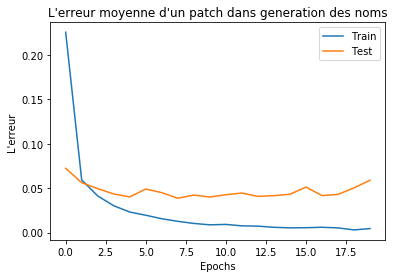

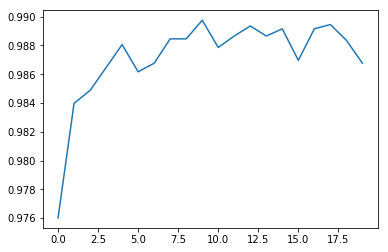

In [143]:
print_losses_and_acc(train_losses, test_losses, accuracys)

# Execute pruning
For given model, execute SNIP pruning using one batch of 128 examples. K is the number of connections to keep.

In [145]:
prune_model = ConvNet()
snip = SNIP(prune_model)
total_param_number = snip.get_total_param_number()
print("Original number of params : {}".format(total_param_number))
K = total_param_number // 10
print("10% of params : {}".format(K))
C_masks = snip.compute_mask(pruning_data_loader, K=K)

train_losses, test_losses, accuracys  = train_model(prune_model, snip);

Original number of params : 61706
10% of params : 6170
=== EPOCH 1 =====

[TRAIN Batch 000/938]	Time 0.051s (0.051s)	Loss 2.2861 (2.2861)	Prec   0.1 (  0.1)

[TRAIN Batch 100/938]	Time 0.003s (0.004s)	Loss 1.5461 (2.1273)	Prec   0.6 (  0.3)

[TRAIN Batch 200/938]	Time 0.003s (0.004s)	Loss 0.8044 (1.6534)	Prec   0.9 (  0.5)

[TRAIN Batch 300/938]	Time 0.006s (0.004s)	Loss 0.4914 (1.3259)	Prec   0.9 (  0.6)

[TRAIN Batch 400/938]	Time 0.003s (0.004s)	Loss 0.5750 (1.1067)	Prec   0.9 (  0.7)

[TRAIN Batch 500/938]	Time 0.004s (0.004s)	Loss 0.2247 (0.9536)	Prec   1.0 (  0.7)

[TRAIN Batch 600/938]	Time 0.004s (0.004s)	Loss 0.2233 (0.8413)	Prec   1.0 (  0.7)

[TRAIN Batch 700/938]	Time 0.005s (0.004s)	Loss 0.3335 (0.7541)	Prec   0.9 (  0.8)

[TRAIN Batch 800/938]	Time 0.003s (0.004s)	Loss 0.2765 (0.6868)	Prec   0.9 (  0.8)

[TRAIN Batch 900/938]	Time 0.004s (0.004s)	Loss 0.1432 (0.6315)	Prec   0.9 (  0.8)


===============> Total time 3s	Avg loss 0.6134	Avg Prec  0.82 %

[EVAL Batch 000/157]

[EVAL Batch 100/157]	Time 0.003s (0.004s)	Loss 0.0661 (0.0562)	Prec   1.0 (  1.0)


===============> Total time 0s	Avg loss 0.0566	Avg Prec  0.98 %

=== EPOCH 8 =====

[TRAIN Batch 000/938]	Time 0.089s (0.089s)	Loss 0.0862 (0.0862)	Prec   1.0 (  1.0)

[TRAIN Batch 100/938]	Time 0.004s (0.005s)	Loss 0.0246 (0.0475)	Prec   1.0 (  1.0)

[TRAIN Batch 200/938]	Time 0.005s (0.004s)	Loss 0.1665 (0.0520)	Prec   0.9 (  1.0)

[TRAIN Batch 300/938]	Time 0.003s (0.004s)	Loss 0.0602 (0.0542)	Prec   1.0 (  1.0)

[TRAIN Batch 400/938]	Time 0.004s (0.004s)	Loss 0.0969 (0.0529)	Prec   1.0 (  1.0)

[TRAIN Batch 500/938]	Time 0.004s (0.004s)	Loss 0.0127 (0.0528)	Prec   1.0 (  1.0)

[TRAIN Batch 600/938]	Time 0.003s (0.004s)	Loss 0.0116 (0.0537)	Prec   1.0 (  1.0)

[TRAIN Batch 700/938]	Time 0.004s (0.004s)	Loss 0.0412 (0.0539)	Prec   1.0 (  1.0)

[TRAIN Batch 800/938]	Time 0.003s (0.004s)	Loss 0.0189 (0.0540)	Prec   1.0 (  1.0)

[TRAIN Batch 900/938]	Time 0.003s (0.004s)	Loss 0.0030 (0.0531)	Prec   1.0 (

[EVAL Batch 000/157]	Time 0.078s (0.078s)	Loss 0.1631 (0.1631)	Prec   1.0 (  1.0)

[EVAL Batch 100/157]	Time 0.005s (0.003s)	Loss 0.0469 (0.0528)	Prec   1.0 (  1.0)


===============> Total time 0s	Avg loss 0.0528	Avg Prec  0.98 %

=== EPOCH 15 =====

[TRAIN Batch 000/938]	Time 0.091s (0.091s)	Loss 0.1346 (0.1346)	Prec   1.0 (  1.0)

[TRAIN Batch 100/938]	Time 0.004s (0.005s)	Loss 0.0036 (0.0370)	Prec   1.0 (  1.0)

[TRAIN Batch 200/938]	Time 0.005s (0.004s)	Loss 0.0139 (0.0362)	Prec   1.0 (  1.0)

[TRAIN Batch 300/938]	Time 0.004s (0.004s)	Loss 0.0167 (0.0375)	Prec   1.0 (  1.0)

[TRAIN Batch 400/938]	Time 0.003s (0.004s)	Loss 0.0100 (0.0360)	Prec   1.0 (  1.0)

[TRAIN Batch 500/938]	Time 0.003s (0.004s)	Loss 0.0487 (0.0361)	Prec   1.0 (  1.0)

[TRAIN Batch 600/938]	Time 0.004s (0.004s)	Loss 0.0202 (0.0371)	Prec   1.0 (  1.0)

[TRAIN Batch 700/938]	Time 0.004s (0.004s)	Loss 0.0074 (0.0365)	Prec   1.0 (  1.0)

[TRAIN Batch 800/938]	Time 0.004s (0.004s)	Loss 0.0864 (0.0370)	Prec   1.0 (

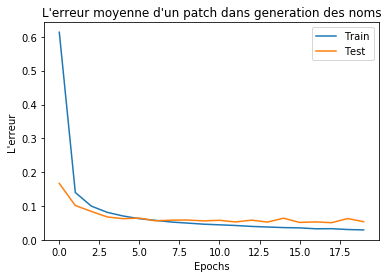

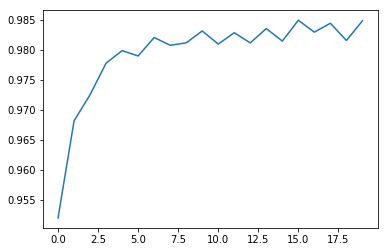

In [146]:
print_losses_and_acc(train_losses, test_losses, accuracys)

### Even less parameters


In [152]:
prune_model = ConvNet()
snip = SNIP(prune_model)
total_param_number = snip.get_total_param_number()
print("Original number of params : {}".format(total_param_number))
K = total_param_number // 25
print("4 %  of params : {}".format(K))
C_masks = snip.compute_mask(pruning_data_loader, K=K)

train_losses, test_losses, accuracys  = train_model(prune_model, snip);

Original number of params : 61706
4 %  of params : 2468
=== EPOCH 1 =====

[TRAIN Batch 000/938]	Time 0.052s (0.052s)	Loss 2.3084 (2.3084)	Prec   0.1 (  0.1)

[TRAIN Batch 100/938]	Time 0.003s (0.004s)	Loss 2.2409 (2.2915)	Prec   0.3 (  0.2)

[TRAIN Batch 200/938]	Time 0.003s (0.004s)	Loss 1.8569 (2.1667)	Prec   0.3 (  0.3)

[TRAIN Batch 300/938]	Time 0.004s (0.004s)	Loss 1.4664 (1.9718)	Prec   0.6 (  0.3)

[TRAIN Batch 400/938]	Time 0.004s (0.004s)	Loss 1.0782 (1.7821)	Prec   0.7 (  0.4)

[TRAIN Batch 500/938]	Time 0.007s (0.004s)	Loss 0.8438 (1.6130)	Prec   0.8 (  0.5)

[TRAIN Batch 600/938]	Time 0.004s (0.004s)	Loss 0.5577 (1.4765)	Prec   0.8 (  0.5)

[TRAIN Batch 700/938]	Time 0.004s (0.004s)	Loss 0.7313 (1.3618)	Prec   0.8 (  0.6)

[TRAIN Batch 800/938]	Time 0.005s (0.004s)	Loss 0.5328 (1.2663)	Prec   0.8 (  0.6)

[TRAIN Batch 900/938]	Time 0.004s (0.004s)	Loss 0.4151 (1.1865)	Prec   0.9 (  0.6)


===============> Total time 3s	Avg loss 1.1609	Avg Prec  0.64 %

[EVAL Batch 000/157

[EVAL Batch 100/157]	Time 0.003s (0.004s)	Loss 0.1993 (0.1359)	Prec   0.9 (  1.0)


===============> Total time 0s	Avg loss 0.1345	Avg Prec  0.96 %

=== EPOCH 8 =====

[TRAIN Batch 000/938]	Time 0.095s (0.095s)	Loss 0.0836 (0.0836)	Prec   1.0 (  1.0)

[TRAIN Batch 100/938]	Time 0.005s (0.005s)	Loss 0.1315 (0.1421)	Prec   0.9 (  1.0)

[TRAIN Batch 200/938]	Time 0.004s (0.005s)	Loss 0.1161 (0.1453)	Prec   1.0 (  1.0)

[TRAIN Batch 300/938]	Time 0.004s (0.004s)	Loss 0.1289 (0.1412)	Prec   1.0 (  1.0)

[TRAIN Batch 400/938]	Time 0.005s (0.004s)	Loss 0.1061 (0.1411)	Prec   1.0 (  1.0)

[TRAIN Batch 500/938]	Time 0.004s (0.004s)	Loss 0.1547 (0.1394)	Prec   0.9 (  1.0)

[TRAIN Batch 600/938]	Time 0.007s (0.004s)	Loss 0.2263 (0.1405)	Prec   1.0 (  1.0)

[TRAIN Batch 700/938]	Time 0.004s (0.004s)	Loss 0.1731 (0.1425)	Prec   0.9 (  1.0)

[TRAIN Batch 800/938]	Time 0.003s (0.004s)	Loss 0.1132 (0.1404)	Prec   0.9 (  1.0)

[TRAIN Batch 900/938]	Time 0.003s (0.004s)	Loss 0.2722 (0.1408)	Prec   0.9 (

[EVAL Batch 000/157]	Time 0.076s (0.076s)	Loss 0.0940 (0.0940)	Prec   1.0 (  1.0)

[EVAL Batch 100/157]	Time 0.005s (0.003s)	Loss 0.1386 (0.0970)	Prec   1.0 (  1.0)


===============> Total time 0s	Avg loss 0.1034	Avg Prec  0.97 %

=== EPOCH 15 =====

[TRAIN Batch 000/938]	Time 0.048s (0.048s)	Loss 0.0736 (0.0736)	Prec   1.0 (  1.0)

[TRAIN Batch 100/938]	Time 0.003s (0.004s)	Loss 0.1058 (0.1137)	Prec   1.0 (  1.0)

[TRAIN Batch 200/938]	Time 0.003s (0.004s)	Loss 0.1682 (0.1075)	Prec   0.9 (  1.0)

[TRAIN Batch 300/938]	Time 0.003s (0.004s)	Loss 0.0797 (0.1059)	Prec   1.0 (  1.0)

[TRAIN Batch 400/938]	Time 0.003s (0.004s)	Loss 0.0924 (0.1062)	Prec   1.0 (  1.0)

[TRAIN Batch 500/938]	Time 0.003s (0.004s)	Loss 0.0874 (0.1067)	Prec   1.0 (  1.0)

[TRAIN Batch 600/938]	Time 0.003s (0.003s)	Loss 0.0406 (0.1076)	Prec   1.0 (  1.0)

[TRAIN Batch 700/938]	Time 0.003s (0.003s)	Loss 0.1474 (0.1080)	Prec   1.0 (  1.0)

[TRAIN Batch 800/938]	Time 0.003s (0.003s)	Loss 0.0343 (0.1068)	Prec   1.0 (

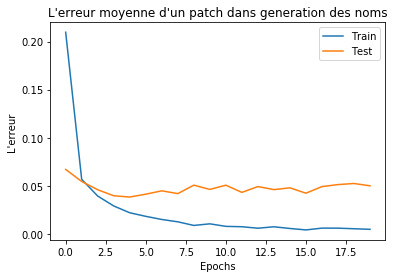

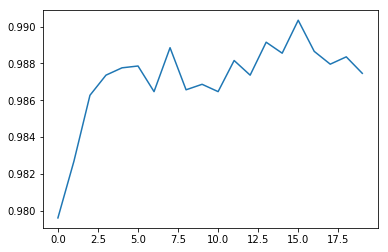

In [151]:
print_losses_and_acc(train_losses, test_losses, accuracys)

### Very small model

In [155]:
prune_model = ConvNet()
snip = SNIP(prune_model)
total_param_number = snip.get_total_param_number()
print("Original number of params : {}".format(total_param_number))
K = total_param_number // 50
print("2 %  of params : {}".format(K))
C_masks = snip.compute_mask(pruning_data_loader, K=K)

train_losses, test_losses, accuracys  = train_model(prune_model, snip);

Original number of params : 61706
2 %  of params : 1234
=== EPOCH 1 =====

[TRAIN Batch 000/938]	Time 0.054s (0.054s)	Loss 2.3014 (2.3014)	Prec   0.1 (  0.1)

[TRAIN Batch 100/938]	Time 0.003s (0.004s)	Loss 2.2979 (2.3008)	Prec   0.1 (  0.1)

[TRAIN Batch 200/938]	Time 0.003s (0.004s)	Loss 2.1726 (2.2625)	Prec   0.2 (  0.2)

[TRAIN Batch 300/938]	Time 0.004s (0.004s)	Loss 2.0315 (2.1946)	Prec   0.1 (  0.2)

[TRAIN Batch 400/938]	Time 0.003s (0.004s)	Loss 1.9132 (2.1310)	Prec   0.3 (  0.2)

[TRAIN Batch 500/938]	Time 0.004s (0.004s)	Loss 1.8638 (2.0750)	Prec   0.4 (  0.2)

[TRAIN Batch 600/938]	Time 0.004s (0.004s)	Loss 1.8837 (2.0220)	Prec   0.3 (  0.3)

[TRAIN Batch 700/938]	Time 0.004s (0.004s)	Loss 1.6133 (1.9736)	Prec   0.4 (  0.3)

[TRAIN Batch 800/938]	Time 0.004s (0.004s)	Loss 1.5976 (1.9292)	Prec   0.3 (  0.3)

[TRAIN Batch 900/938]	Time 0.003s (0.004s)	Loss 1.5080 (1.8868)	Prec   0.4 (  0.3)


===============> Total time 3s	Avg loss 1.8718	Avg Prec  0.31 %

[EVAL Batch 000/157

[EVAL Batch 100/157]	Time 0.001s (0.003s)	Loss 0.9225 (0.7739)	Prec   0.7 (  0.8)


===============> Total time 0s	Avg loss 0.7706	Avg Prec  0.75 %

=== EPOCH 8 =====

[TRAIN Batch 000/938]	Time 0.080s (0.080s)	Loss 0.8241 (0.8241)	Prec   0.8 (  0.8)

[TRAIN Batch 100/938]	Time 0.005s (0.005s)	Loss 0.6545 (0.7777)	Prec   0.8 (  0.8)

[TRAIN Batch 200/938]	Time 0.003s (0.004s)	Loss 0.7094 (0.7821)	Prec   0.8 (  0.8)

[TRAIN Batch 300/938]	Time 0.004s (0.004s)	Loss 0.9675 (0.7808)	Prec   0.8 (  0.8)

[TRAIN Batch 400/938]	Time 0.006s (0.004s)	Loss 0.7426 (0.7835)	Prec   0.7 (  0.8)

[TRAIN Batch 500/938]	Time 0.004s (0.004s)	Loss 0.9558 (0.7836)	Prec   0.7 (  0.8)

[TRAIN Batch 600/938]	Time 0.004s (0.004s)	Loss 0.6422 (0.7812)	Prec   0.7 (  0.8)

[TRAIN Batch 700/938]	Time 0.007s (0.004s)	Loss 0.8311 (0.7808)	Prec   0.8 (  0.8)

[TRAIN Batch 800/938]	Time 0.004s (0.004s)	Loss 0.7736 (0.7819)	Prec   0.8 (  0.8)

[TRAIN Batch 900/938]	Time 0.004s (0.004s)	Loss 0.9765 (0.7787)	Prec   0.7 (

[EVAL Batch 000/157]	Time 0.079s (0.079s)	Loss 0.5852 (0.5852)	Prec   0.8 (  0.8)

[EVAL Batch 100/157]	Time 0.001s (0.004s)	Loss 0.6581 (0.6439)	Prec   0.7 (  0.8)


===============> Total time 0s	Avg loss 0.6451	Avg Prec  0.81 %

=== EPOCH 15 =====

[TRAIN Batch 000/938]	Time 0.087s (0.087s)	Loss 0.6130 (0.6130)	Prec   0.9 (  0.9)

[TRAIN Batch 100/938]	Time 0.005s (0.004s)	Loss 0.7384 (0.6815)	Prec   0.7 (  0.8)

[TRAIN Batch 200/938]	Time 0.003s (0.004s)	Loss 0.7378 (0.6900)	Prec   0.8 (  0.8)

[TRAIN Batch 300/938]	Time 0.003s (0.004s)	Loss 0.6564 (0.6766)	Prec   0.9 (  0.8)

[TRAIN Batch 400/938]	Time 0.004s (0.004s)	Loss 0.7257 (0.6792)	Prec   0.8 (  0.8)

[TRAIN Batch 500/938]	Time 0.004s (0.004s)	Loss 0.6506 (0.6757)	Prec   0.8 (  0.8)

[TRAIN Batch 600/938]	Time 0.003s (0.004s)	Loss 0.7595 (0.6739)	Prec   0.7 (  0.8)

[TRAIN Batch 700/938]	Time 0.003s (0.004s)	Loss 0.6900 (0.6689)	Prec   0.8 (  0.8)

[TRAIN Batch 800/938]	Time 0.003s (0.004s)	Loss 0.8281 (0.6686)	Prec   0.8 (

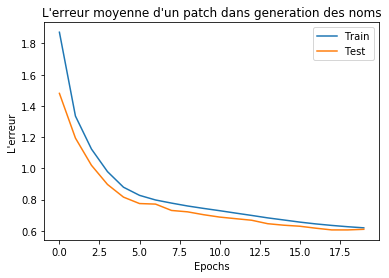

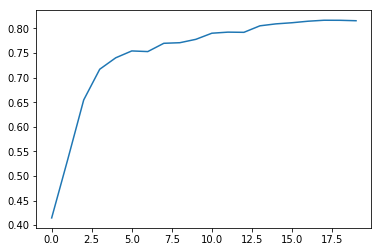

In [156]:
print_losses_and_acc(train_losses, test_losses, accuracys)

### 1.5 % params

In [165]:
prune_model = ConvNet()
snip = SNIP(prune_model)
total_param_number = snip.get_total_param_number()
print("Original number of params : {}".format(total_param_number))
K = int(total_param_number * 0.015)
print("1.5 %  of params : {}".format(K))
C_masks = snip.compute_mask(pruning_data_loader, K=K)

train_losses, test_losses, accuracys  = train_model(prune_model, snip);

Original number of params : 61706
1.5 %  of params : 925
=== EPOCH 1 =====

[TRAIN Batch 000/938]	Time 0.056s (0.056s)	Loss 2.3061 (2.3061)	Prec   0.0 (  0.0)

[TRAIN Batch 100/938]	Time 0.004s (0.005s)	Loss 2.3037 (2.3018)	Prec   0.1 (  0.1)

[TRAIN Batch 200/938]	Time 0.004s (0.005s)	Loss 2.2748 (2.2987)	Prec   0.2 (  0.1)

[TRAIN Batch 300/938]	Time 0.004s (0.005s)	Loss 2.1327 (2.2641)	Prec   0.3 (  0.2)

[TRAIN Batch 400/938]	Time 0.004s (0.004s)	Loss 1.8606 (2.1989)	Prec   0.3 (  0.2)

[TRAIN Batch 500/938]	Time 0.004s (0.004s)	Loss 1.7766 (2.1292)	Prec   0.4 (  0.2)

[TRAIN Batch 600/938]	Time 0.004s (0.004s)	Loss 1.7691 (2.0679)	Prec   0.3 (  0.2)

[TRAIN Batch 700/938]	Time 0.004s (0.004s)	Loss 1.5641 (2.0160)	Prec   0.4 (  0.3)

[TRAIN Batch 800/938]	Time 0.004s (0.004s)	Loss 1.6872 (1.9721)	Prec   0.4 (  0.3)

[TRAIN Batch 900/938]	Time 0.003s (0.004s)	Loss 1.6510 (1.9357)	Prec   0.3 (  0.3)


===============> Total time 3s	Avg loss 1.9228	Avg Prec  0.28 %

[EVAL Batch 000/15

[EVAL Batch 100/157]	Time 0.004s (0.003s)	Loss 0.9671 (0.9821)	Prec   0.8 (  0.7)


===============> Total time 0s	Avg loss 0.9969	Avg Prec  0.69 %

=== EPOCH 8 =====

[TRAIN Batch 000/938]	Time 0.081s (0.081s)	Loss 0.8332 (0.8332)	Prec   0.7 (  0.7)

[TRAIN Batch 100/938]	Time 0.004s (0.004s)	Loss 1.0637 (1.0137)	Prec   0.6 (  0.7)

[TRAIN Batch 200/938]	Time 0.004s (0.004s)	Loss 1.1729 (1.0215)	Prec   0.6 (  0.7)

[TRAIN Batch 300/938]	Time 0.003s (0.004s)	Loss 1.1127 (1.0199)	Prec   0.6 (  0.7)

[TRAIN Batch 400/938]	Time 0.003s (0.004s)	Loss 0.9785 (1.0214)	Prec   0.7 (  0.7)

[TRAIN Batch 500/938]	Time 0.003s (0.004s)	Loss 1.3160 (1.0243)	Prec   0.6 (  0.7)

[TRAIN Batch 600/938]	Time 0.003s (0.004s)	Loss 0.8724 (1.0250)	Prec   0.7 (  0.7)

[TRAIN Batch 700/938]	Time 0.003s (0.004s)	Loss 0.8305 (1.0224)	Prec   0.7 (  0.7)

[TRAIN Batch 800/938]	Time 0.004s (0.004s)	Loss 1.2171 (1.0204)	Prec   0.7 (  0.7)

[TRAIN Batch 900/938]	Time 0.003s (0.004s)	Loss 0.7871 (1.0169)	Prec   0.8 (

[EVAL Batch 000/157]	Time 0.077s (0.077s)	Loss 0.7975 (0.7975)	Prec   0.7 (  0.7)

[EVAL Batch 100/157]	Time 0.004s (0.003s)	Loss 1.1188 (0.9070)	Prec   0.7 (  0.7)


===============> Total time 0s	Avg loss 0.9154	Avg Prec  0.72 %

=== EPOCH 15 =====

[TRAIN Batch 000/938]	Time 0.078s (0.078s)	Loss 1.2433 (1.2433)	Prec   0.6 (  0.6)

[TRAIN Batch 100/938]	Time 0.004s (0.004s)	Loss 1.1173 (0.9964)	Prec   0.6 (  0.7)

[TRAIN Batch 200/938]	Time 0.003s (0.004s)	Loss 0.9265 (0.9804)	Prec   0.7 (  0.7)

[TRAIN Batch 300/938]	Time 0.004s (0.004s)	Loss 0.7150 (0.9675)	Prec   0.8 (  0.7)

[TRAIN Batch 400/938]	Time 0.004s (0.004s)	Loss 0.9645 (0.9593)	Prec   0.7 (  0.7)

[TRAIN Batch 500/938]	Time 0.003s (0.004s)	Loss 1.0543 (0.9622)	Prec   0.6 (  0.7)

[TRAIN Batch 600/938]	Time 0.004s (0.004s)	Loss 0.7974 (0.9605)	Prec   0.8 (  0.7)

[TRAIN Batch 700/938]	Time 0.003s (0.004s)	Loss 0.9777 (0.9587)	Prec   0.7 (  0.7)

[TRAIN Batch 800/938]	Time 0.004s (0.004s)	Loss 1.0236 (0.9571)	Prec   0.7 (

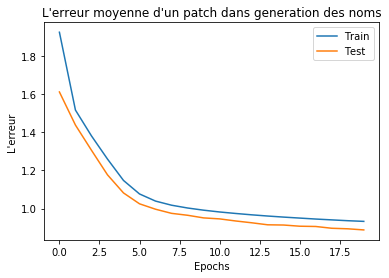

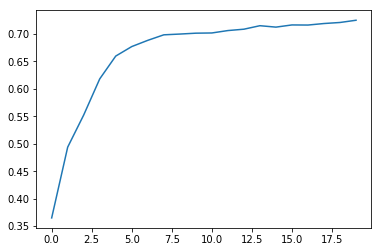

In [166]:
print_losses_and_acc(train_losses, test_losses, accuracys)

### Super small model

In [157]:
prune_model = ConvNet()
snip = SNIP(prune_model)
total_param_number = snip.get_total_param_number()
print("Original number of params : {}".format(total_param_number))
K = total_param_number // 100
print("1 %  of params : {}".format(K))
C_masks = snip.compute_mask(pruning_data_loader, K=K)

train_losses, test_losses, accuracys  = train_model(prune_model, snip);

Original number of params : 61706
1 %  of params : 617
=== EPOCH 1 =====

[TRAIN Batch 000/938]	Time 0.052s (0.052s)	Loss 2.3113 (2.3113)	Prec   0.1 (  0.1)

[TRAIN Batch 100/938]	Time 0.005s (0.004s)	Loss 2.3019 (2.3029)	Prec   0.1 (  0.1)

[TRAIN Batch 200/938]	Time 0.003s (0.004s)	Loss 2.2949 (2.3027)	Prec   0.1 (  0.1)

[TRAIN Batch 300/938]	Time 0.005s (0.004s)	Loss 2.3047 (2.3024)	Prec   0.1 (  0.1)

[TRAIN Batch 400/938]	Time 0.004s (0.004s)	Loss 2.2966 (2.3023)	Prec   0.2 (  0.1)

[TRAIN Batch 500/938]	Time 0.004s (0.004s)	Loss 2.2950 (2.3022)	Prec   0.2 (  0.1)

[TRAIN Batch 600/938]	Time 0.003s (0.004s)	Loss 2.3006 (2.3020)	Prec   0.1 (  0.1)

[TRAIN Batch 700/938]	Time 0.004s (0.004s)	Loss 2.2959 (2.3020)	Prec   0.1 (  0.1)

[TRAIN Batch 800/938]	Time 0.003s (0.004s)	Loss 2.2996 (2.3020)	Prec   0.1 (  0.1)

[TRAIN Batch 900/938]	Time 0.003s (0.004s)	Loss 2.3100 (2.3017)	Prec   0.1 (  0.1)


===============> Total time 3s	Avg loss 2.3016	Avg Prec  0.11 %

[EVAL Batch 000/157]

[EVAL Batch 100/157]	Time 0.004s (0.004s)	Loss 2.2949 (2.3007)	Prec   0.1 (  0.1)


===============> Total time 0s	Avg loss 2.3011	Avg Prec  0.11 %

=== EPOCH 8 =====

[TRAIN Batch 000/938]	Time 0.087s (0.087s)	Loss 2.3040 (2.3040)	Prec   0.1 (  0.1)

[TRAIN Batch 100/938]	Time 0.004s (0.004s)	Loss 2.3030 (2.3016)	Prec   0.1 (  0.1)

[TRAIN Batch 200/938]	Time 0.004s (0.004s)	Loss 2.2981 (2.3012)	Prec   0.1 (  0.1)

[TRAIN Batch 300/938]	Time 0.003s (0.004s)	Loss 2.3029 (2.3014)	Prec   0.1 (  0.1)

[TRAIN Batch 400/938]	Time 0.004s (0.004s)	Loss 2.2942 (2.3015)	Prec   0.2 (  0.1)

[TRAIN Batch 500/938]	Time 0.003s (0.004s)	Loss 2.2916 (2.3014)	Prec   0.2 (  0.1)

[TRAIN Batch 600/938]	Time 0.004s (0.004s)	Loss 2.3027 (2.3014)	Prec   0.1 (  0.1)

[TRAIN Batch 700/938]	Time 0.007s (0.004s)	Loss 2.3114 (2.3012)	Prec   0.1 (  0.1)

[TRAIN Batch 800/938]	Time 0.004s (0.004s)	Loss 2.2989 (2.3014)	Prec   0.1 (  0.1)

[TRAIN Batch 900/938]	Time 0.004s (0.004s)	Loss 2.3030 (2.3014)	Prec   0.1 (

[EVAL Batch 000/157]	Time 0.082s (0.082s)	Loss 2.3083 (2.3083)	Prec   0.1 (  0.1)

[EVAL Batch 100/157]	Time 0.002s (0.003s)	Loss 2.3108 (2.3002)	Prec   0.0 (  0.1)


===============> Total time 0s	Avg loss 2.3010	Avg Prec  0.11 %

=== EPOCH 15 =====

[TRAIN Batch 000/938]	Time 0.078s (0.078s)	Loss 2.3077 (2.3077)	Prec   0.1 (  0.1)

[TRAIN Batch 100/938]	Time 0.004s (0.004s)	Loss 2.3096 (2.3015)	Prec   0.1 (  0.1)

[TRAIN Batch 200/938]	Time 0.004s (0.004s)	Loss 2.2904 (2.3013)	Prec   0.2 (  0.1)

[TRAIN Batch 300/938]	Time 0.005s (0.004s)	Loss 2.3006 (2.3013)	Prec   0.1 (  0.1)

[TRAIN Batch 400/938]	Time 0.004s (0.004s)	Loss 2.2997 (2.3013)	Prec   0.1 (  0.1)

[TRAIN Batch 500/938]	Time 0.004s (0.004s)	Loss 2.2896 (2.3014)	Prec   0.2 (  0.1)

[TRAIN Batch 600/938]	Time 0.004s (0.004s)	Loss 2.3091 (2.3014)	Prec   0.0 (  0.1)

[TRAIN Batch 700/938]	Time 0.004s (0.004s)	Loss 2.3112 (2.3013)	Prec   0.1 (  0.1)

[TRAIN Batch 800/938]	Time 0.004s (0.004s)	Loss 2.2915 (2.3014)	Prec   0.2 (

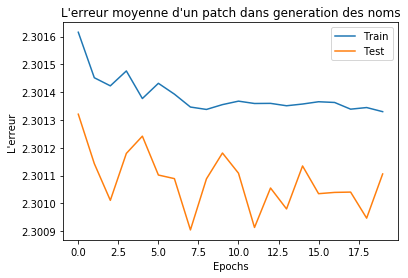

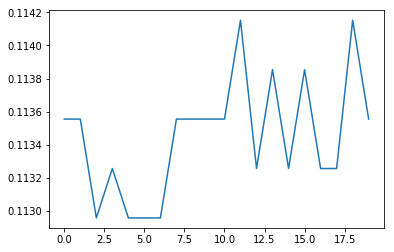

In [158]:
print_losses_and_acc(train_losses, test_losses, accuracys)